# Testing Notebook

### Imports and Data Input

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
import time
import data_files

"""Import Data"""
data = data_files.runs_dict

In [27]:
"""Display summary of all available data"""
# data_files.file_summary

'Display summary of all available data'

### Dashboard of Chosen Run

File                            L230414.CSV
Run                                  Run 31
Time (min)                        50.016667
Max Speed (kts)                   24.297895
Avg Speed (kts)                   12.437385
Battery Expended (%)                     42
Distance Traveled (nm)             5.333644
Average Consumption (kWh/nm)       4.960961
Name: 30, dtype: object


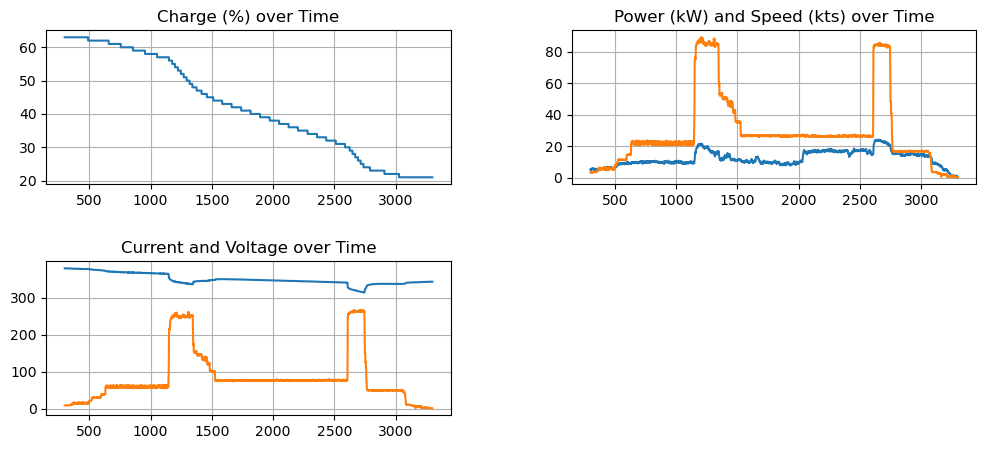

In [28]:
"""Pick a run and show overview of interesting data"""
run = 31

df = data['Run %i' % run]
print(data_files.file_summary.iloc[run-1])  # print summary values of run

'''Summary Plots'''
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
plt.plot(df.index, df['SOC 1 %'])
plt.grid()
plt.title('Charge (%) over Time')

plt.subplot(2,2,2)
plt.plot(df.index, df['Speed kts'], df['Power 1 kW'])
plt.grid()
plt.title('Power (kW) and Speed (kts) over Time')

plt.subplot(2,2,3)
plt.plot(df.index, df['Pack Voltage 1 V'], df['Pack Current 1 A'])
plt.grid()
plt.title('Current and Voltage over Time')

# plt.subplot(2,2,4)
# plt.plot(df.index)
# plt.grid()
# plt.title('Empty')

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.3)

### Define Algorithms

In [29]:

def overall_avg(datastream):
    '''Time consumption version'''
    avg_consumption = datastream['energyUsed']/datastream['tripDuration']           # kWh/min
    time_remaining = datastream['soc']*58/100/avg_consumption                       # min
    range_remaining = time_remaining*(datastream['sog']/60)                         # nm

    '''Distance consumption version'''
    # avg_consumption = datastream['energyUsed']/datastream['tripDistance']           #kWh/nm
    # range_remaining = (datastream['soc']*58/100)/avg_consumption                    #nautical miles

    return avg_consumption, time_remaining, range_remaining


def rolling_avg(data, batt_cap, N):
    """This function is based on a rolling average consumption rate of N data points.
    Any consumption rates that are not valid, or within the first N data points of the run,
    will default to using the stored average consumption rate."""

    dist_list = []

    cached_avg = data_files.file_summary.iloc[run-1]['Average Consumption (kWh/nm)']       # need a cached average value to default to 
    for i in range(len(data)):
        batt = data['SOC 1 %'].iloc[i]*batt_cap/100
        roll_batt_consumed = (data['SOC 1 %'].iloc[i-N] - data['SOC 1 %'].iloc[i])*batt_cap/100          #kWh
        roll_dist_traveled = (data['Distance nm'].iloc[i] - data['Distance nm'].iloc[i-N])                  #nm
        roll_consumption = roll_batt_consumed/roll_dist_traveled                                            #kWh/nm
        
        if i < N or roll_consumption==0:
            dist_remaining = batt/cached_avg      # This will need to change because we won't know the average with real-time data
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining %.1f nm' % (i, batt, cached_avg, dist_remaining), end=' \r')
            # time.sleep(0.001)
        else:
            dist_remaining = batt/roll_consumption   #nm
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining: %.2f nm' % (i, batt, roll_consumption, dist_remaining), end=' \r')
            # time.sleep(.001)

        dist_list.append(dist_remaining)

    return dist_list



def update_average():
    """This is a function to update the stored average consumption of the vessel."""

    pass


# Testing by Class Imports

In [30]:
from testing_class import testing
from algorithm_class import Range_est

In [31]:
'''Add missing variables to DataFrame'''
df2 = testing().add_variables(df)
df2['Consumption'] = ''
df2['Range'] = ''

"""Test Loop"""
for i in range(len(df2)):
    dataStream = testing().parse_csv(df2.iloc[i])
    avg_consumption, time_remaining, range_remaining = overall_avg(dataStream)       # Range_est.overall_avg(dataStream)
    
    print('Battery Remaining = %.1f percent | Range Remaining = %.1f nm' % (dataStream['soc'], range_remaining), end=' \r')
    # time.sleep(.001)
    '''End Algorithm Test'''

    '''Begin data analysis for accuracy'''
    df2['Consumption'].iloc[i] = avg_consumption
    df2['Range'].iloc[i] = range_remaining


/home/rtostrander/photon-range-estimator/testing_class.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tripDistance'].iloc[i] = (df['Distance km'].iloc[i] - df['Distance km'].iloc[0])*.539957    # nautical miles
/home/rtostrander/photon-range-estimator/testing_class.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tripDuration'].iloc[i] = (df['Time'].iloc[i] - df['Time'].iloc[0]).seconds/60               # min
/home/rtostrander/photon-range-estimator/testing_class.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

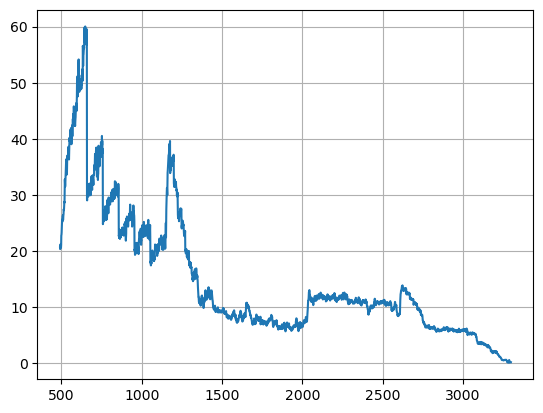

In [32]:
'''Plot range over time'''
plt.plot(df2.index, df2['Range'])
plt.grid()

# Accuracy Comparison

In [33]:
'''Look at how far the vessel traveled 30s later'''

df['Dist Prediction (nm)'] = dist_list
df['Interval Dist'] = ''
df['Interval Pred'] = ''
df['error'] = ''

interval = 30 #seconds
# for i in range(interval, len(df)):
#     interval_dist = df['Distance nm'].iloc[i] - df['Distance nm'].iloc[i-interval]
#     # interval_pred = df['Dist Prediction (nm)'].iloc[i-interval] - df['Dist Prediction (nm)'][i]
#     df['Interval Dist'].iloc[i] = interval_dist
#     # df['Interval Pred'].iloc[i] = interval_pred

dist_500 = df['Distance nm'].iloc[-1] - df['Distance nm'].iloc[500] # Distance traveled from i=500 on
pred_500 = df['Dist Prediction (nm)'].iloc[500] - df['Dist Prediction (nm)'].iloc[-1] 
print(pred_500, dist_500)

ValueError: Length of values (0) does not match length of index (3000)